In [1]:
import talk.config as con

con.config_configManager()
con.config_matplotlib()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Location problem

We want to find the smallest circle such that $n$ points are all contained in it.


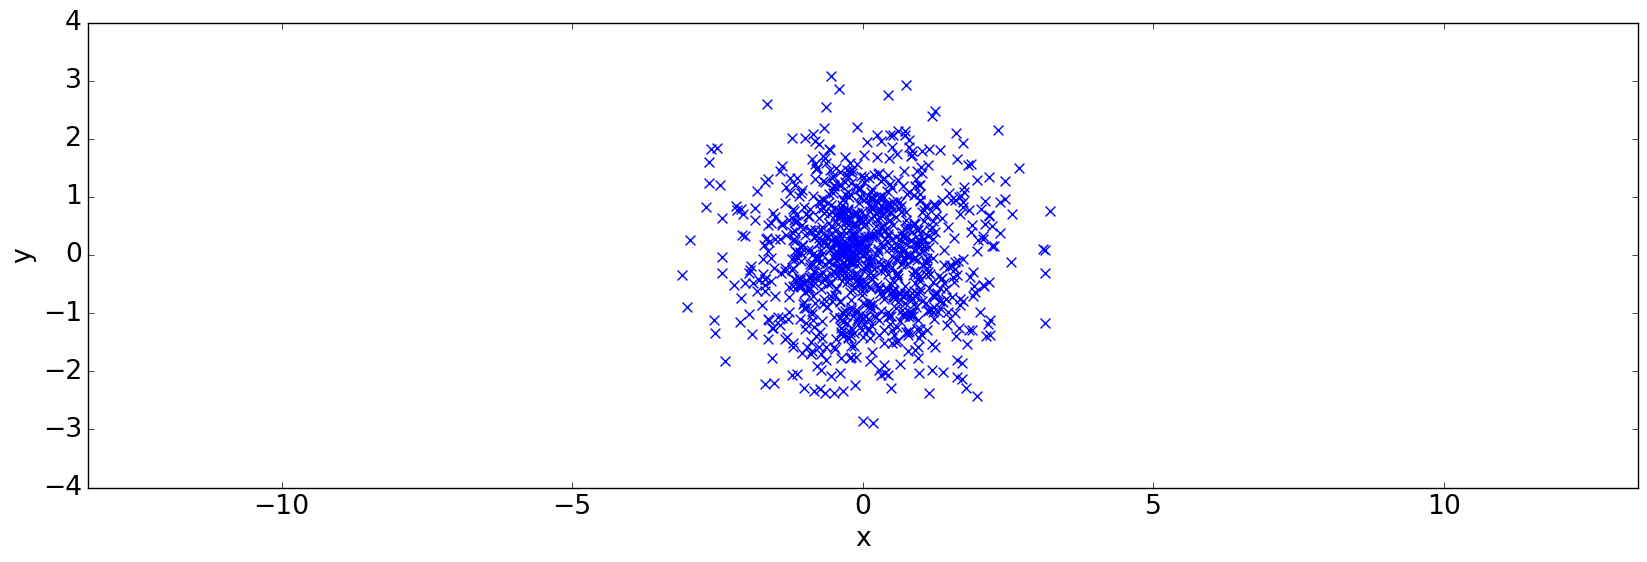

In [2]:
# pick a bunch of random points
import numpy as np
pos = np.random.randn(1000,2)

import matplotlib.pyplot as plt
plt.scatter(pos[:,0], pos[:,1],s=50,marker=u'x')
plt.xlabel('x'), plt.ylabel('y')
plt.axis('equal')
plt.show()

Solution with Mosek

from mosek.fusion import *

def __two_norm(model, v):
    t = model.variable(1, Domain.greaterThan(0.0))
    model.constraint(Expr.vstack(t, v), Domain.inQCone())
    return t


with Model('center') as model:
    #variable for the center
    p = model.variable('p', 2, Domain.unbounded())
    R = model.variable('r', 1, Domain.unbounded())
    
    #distances for each point from the centre
    distances = Expr.vstack([__two_norm(model, Expr.sub(Expr.constTerm(row), p)).asExpr() for row in pos])
    
    #enforce that each distance is smaller than R
    model.constraint(Expr.sub(Var.repeat(R, distances.size()), distances), Domain.greaterThan(0.0))
    
    #minimize R
    model.objective(ObjectiveSense.Minimize, R)
    model.solve()
    
    midpoint = np.array(p.level())
    radius = R.level()[0]
    

In [20]:
# solution with cvxpy

import cvxpy as cvx
R = cvx.Variable(1)
x = cvx.Variable(2)
cvx.Problem(objective = cvx.Minimize(R), 
            constraints = [cvx.norm(row-x,2) <= R for row in pos]).solve()

radius = R.value
midpoint = np.array([x[0].value, x[1].value])
print(midpoint)
print(radius)

[ 0.10537745  0.02164951]
3.26019992299


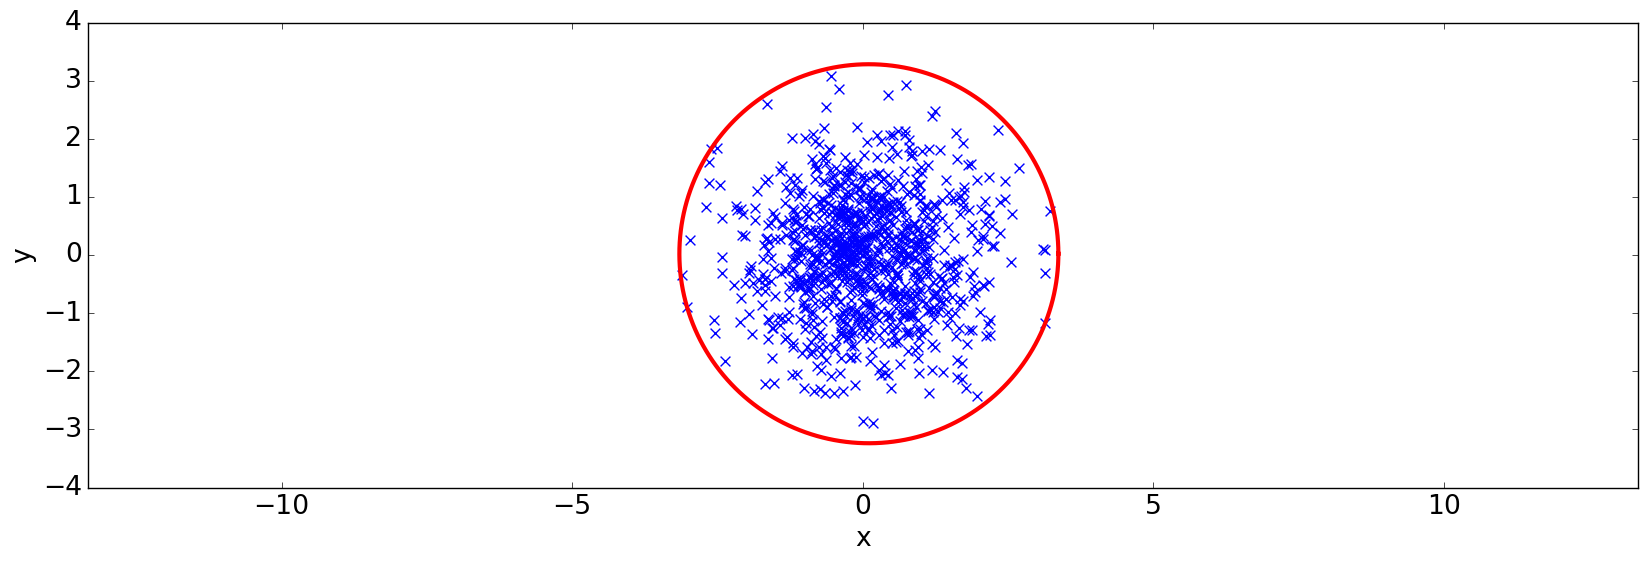

[ 0.10537745  0.02164951]
3.26019992299


In [19]:
import math
c=np.array([[radius*np.cos(a)+midpoint[0], radius*np.sin(a)+midpoint[1]] for a in np.linspace(0,2*math.pi,1000)])

import matplotlib.pyplot as plt
plt.plot(c[:,0],c[:,1],'r')
plt.scatter(pos[:,0], pos[:,1],s=50,marker=u'x')
plt.xlabel('x'), plt.ylabel('y')
plt.axis('equal')
plt.show()

# Summary

- We solved the location problem for $n$ points introducing $n$ cones each of dimension $3$.

- It is trivial to generalize for points in higher dimensional spaces.

- However, all of this fails once we can construct multiple circles.